# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2019/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

*If you fail to follow these simple instructions, it will negatively impact your grade!*

**Due date and time**: The assignment is due on Tuesday November 5th at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/.

# Part 1: Twitter Network Analysis

_Exercise_ 1: Build the network of retweets.
We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets. You can build the network following the steps below (and you should  be able to reuse many of the functions you have written as part of the exercises during the previous weeks):

* Consider the 200 most recent tweets written by each member of the house (use the files [here](https://github.com/suneman/socialgraphs2019/tree/master/files/data_twitter/tweets_2019.zip/). For each file, use a regular expression to find retweets and to extract the Twitter handle of the user whose content was retweeted. All retweets begin with "*RT @originalAuthor:*", where "*originalAuthor*" is the handle of the user whose content was retweeted (and the part of the text you want to extract).
* For each retweet, check if the handle retweeted is, in fact, the handle of a member of the house. If yes, keep it. If no, discard it.
* Use a NetworkX [`DiGraph`](https://networkx.github.io/documentation/development/reference/classes.digraph.html) to store the network. Use weighted edges to account for multiple retweets. Also store the party of each member as a node attribute (use the data in [this file](https://github.com/suneman/socialgraphs2019/blob/master/files/data_twitter/H115_tw_2019.csv). Remove self-loops (edges that connect a node with itself).


In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import re
import io
import networkx as nx

In [5]:
# Path to files
path = './data/tweets_2019_full/'

# Load the data of politicians and sort them by WikiPageName
df = pd.read_csv('./data/H115_tw_2019.csv', encoding = 'utf-8')

# Get the politicians and their corresponing parties and user handles
politicians = np.array(df.WikiPageName)
parties = np.array(df.Party)
user_handles = np.array(df.tw_name)

dim = len(politicians)

# Get the files in the directory
files = [f for f in listdir(path) if isfile(join(path, f))]

# Construct a user handle -> index of politician mapping
h_to_i = {}
for h in user_handles:
    h_to_i[h] = np.where(files == politicians[np.where(user_handles == h)])[0]

# Construct a index -> party mapping
i_to_p = np.zeros(shape=(dim), dtype='<U30')
for i, p in enumerate(files):
    i_to_p[i] = (parties[np.where(politicians == p)])[0]

In [6]:
# Init a nx.DiGraph
G = nx.DiGraph()
G.add_nodes_from(list(range(dim)))

for i in range(dim):
    G.nodes[i]['Party'] = i_to_p[i]

in_weights = np.zeros(shape=dim, dtype='int')
out_weights = np.zeros(shape=dim, dtype='int')
    
# Loop over all files
for idx_from, f in enumerate(files):
    
    # Init an index -> weight mapping
    i_to_w = {}
    # Open the file of the corresponding politician
    data = io.open("{}{}".format(path, f), 'r', encoding='utf-8').read()
    # Find all retweets using regular expressions
    retweets = re.findall("RT @.*?:", data)
    
    # Loop over retweets
    for retweet in retweets:
        # Extract the user handle
        user_handle = retweet[4:-1]
        # Check if the user_handle is of a member of the house
        if user_handle in user_handles:
            # Map the user handle to the corresponding index
            idx_to = h_to_i[user_handle][0]
            # Increment the weight by one if idx_to is known
            if idx_to in i_to_w.keys():
                i_to_w[idx_to] += 1
            # Otherwise, set the weight to one
            else:
                i_to_w[idx_to] = 1
            # Increment the incoming weight of the target node
            in_weights[idx_to] += 1
            # Increment the outgoing weight of the source node
            out_weights[idx_from] += 1
    
    # Loop over the index -> weight mapping
    for idx_to, w in i_to_w.items():
        # Add the edge to the graph if not a self-loop
        if idx_from != idx_to:
            G.add_edge(idx_from, idx_to, weight=w)
       

 _Exercise_ 2: Visualize the network of retweets and investigate differences between the parties.
 * Visualize the network using the [Networkx draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and nodes coordinates from the force atlas algorithm. *Hint: use an undirected version of the graph to find the nodes positions for better results, but stick to the directed version for all measurements.* Plot nodes in colors according to their party (e.g. 'red' for republicans and 'blue' for democrats) and set the node-size to be proportional to total degree. 
  * Compare the network of Retweets with the network of Wikipedia pages (generated during Week 5). Do you observe any differences? How do you explain them?
* Now set the node-size tob proportional to betweenness centrality. Do you observe any changes?
* Repeat the point above using eigenvector centrality. Again, do you see a difference? Can you explain why based on what eigenvector centrality measures?
* Who are the three nodes with highest degree within each party? And wbat is their eigenvector centrality? And their betweenness centrality?
* Plot (on the same figure) the distribution of outgoing strength for the republican and democratic nodes repectively (i.e. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?
* Find the 3 members of the republican party that have retweeted tweets from democratic members most often. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?

In [7]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt

# Init force atlas 2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=0.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.12,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=120.0,

                        # Log
                        verbose=True)

# Form a degree vector
d = dict(nx.degree(G))

# Construct a vector of colors indicating the party of the politicians
cols = []
for n in G.nodes:
    if G.nodes[n]['Party'] == 'Democratic': 
        cols.append('navy') 
    else: 
        cols.append('maroon')

# Use undirected version of the graph for visualizations
H = G.to_undirected()
        
positions = forceatlas2.forceatlas2_networkx_layout(H, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:10<00:00, 190.00it/s]

BarnesHut Approximation  took  0.85  seconds
Repulsion forces  took  9.28  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.13  seconds


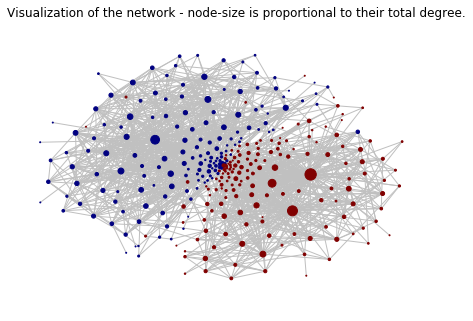

In [8]:
nx.draw(H, positions, node_size=[v for v in d.values()], with_labels=False, 
        node_color=cols, edge_color="silver", edge_width=0.5, arrows=False)
plt.title('Visualization of the network - node-size is proportional to their total degree.')
plt.show()

Compared to the network of Wikipedia pages, this network is more clearly divided into two large components according to the parties of the politicians. In the network of Wikipedia pages, the distribution of nodes doesn't similarly follow the distribution of parties. The most likely reason for this observation, is that the links between Wikipedia have different meanings and the distribution of links between Wikipedia pages doesn't accurately follow the distribution of parties. The links formed from retweets, on the other hand, are a clearly better indicator of political parties.

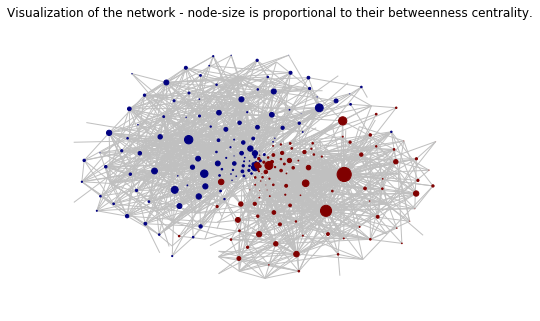

In [9]:
b = nx.betweenness_centrality(G)
nx.draw(H, positions, node_size=[1000 * v for v in b.values()], with_labels=False, 
        node_color=cols, edge_color="silver", edge_width=0.5, arrows=False)
plt.title('Visualization of the network - node-size is proportional to their betweenness centrality.')
plt.show()

From this visualization, it can be seen that high degree and high betweenness centrality are somewhat correlated. However, the proportional difference between high-degree nodes and low-degree nodes seems to be considerably smaller than with betweenness centrality.

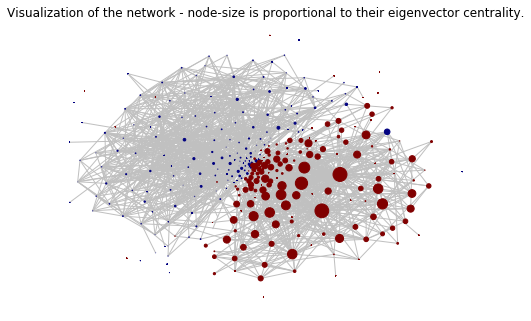

In [10]:
e = nx.eigenvector_centrality(G)
nx.draw(H, positions, node_size=[500 * v for v in e.values()], with_labels=False, 
        node_color=cols, edge_color="silver", edge_width=0.5, arrows=False)
plt.title('Visualization of the network - node-size is proportional to their eigenvector centrality.')
plt.show()

The visualization above depicts how Republicans have clearly larger values of eigenvector centrality compared to Democrats on average, which may indicate relevant structural differences between these two parties. Here it is crucial to remember that eigenvector centrality of a node is proportional to the importance of its neighbors. This implies that 'popular' Republicans may be well connected with other popular Republicans giving them a high centrality with this metric. This indirectly boosts the centrality of their (less-popular) neighbors, which again further boosts the centrality of their (even less popular) neighbors and so on. In addition, popular Republican politicians have on average higher degree than their Democratic counterparts which further boosts this effect. Democrats, on the other hand, don't similarly seem to favor connections between 'popular' people, which has a similar escalating effect but into opposite direction.

In [11]:
top_dem = []
top_rep = []
# Construct a degree -> index mapping
d_to_i = sorted([(v, k) for k, v in d.items()])
# Reverse order
d_to_i.reverse()
for _, i in d_to_i:
    party = G.nodes[i]['Party']
    if party == 'Democratic' and len(top_dem) < 3:
        top_dem.append(i)
    if party == 'Republican' and len(top_rep) < 3:
        top_rep.append(i)

print('Top-3 Democrats by degree:')
for i in top_dem:
    print('{}: Degree: {}, Betweenness Centrality: {}, Eigenvector Centrality: {}'.format(files[i], d[i], b[i], e[i]))

print()

print('Top-3 Republicans by degree:')
for i in top_rep:
    print('{}: Degree: {}, Betweenness Centrality: {}, Eigenvector Centrality: {}'.format(files[i], d[i], b[i], e[i]))


Top-3 Democrats by degree:
Nancy_Pelosi: Degree: 76, Betweenness Centrality: 0.0698535089830662, Eigenvector Centrality: 0.013644437276218821
Raúl_Grijalva: Degree: 35, Betweenness Centrality: 0.025318281521537787, Eigenvector Centrality: 0.009793928782238077
Linda_Sánchez: Degree: 35, Betweenness Centrality: 0.03343130452008083, Eigenvector Centrality: 0.0038195892673179195

Top-3 Republicans by degree:
Kevin_McCarthy_(California_politician): Degree: 128, Betweenness Centrality: 0.20012769212916937, Eigenvector Centrality: 0.3896239434251308
Steve_Scalise: Degree: 99, Betweenness Centrality: 0.12279383342396023, Eigenvector Centrality: 0.379452390595441
Andy_Biggs: Degree: 61, Betweenness Centrality: 0.043889423578693604, Eigenvector Centrality: 0.3001000122248723


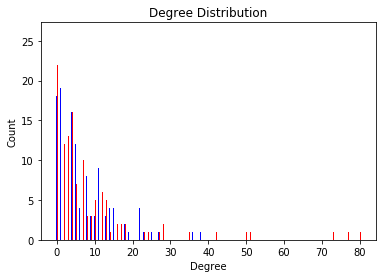

In [12]:
democrats = []
republicans = []
for n in range(dim):
    if G.nodes[n]['Party'] == 'Democratic':
        democrats.append(n)
    if G.nodes[n]['Party'] == 'Republican':
        republicans.append(n)
        

d_bin_count = np.bincount(out_weights[democrats])
d_nz = np.nonzero(d_bin_count)[0]
d_unique_count = dict(zip(d_nz, d_bin_count[d_nz]))
d_x = np.array(list(d_unique_count.keys()), dtype='int') 
d_y = np.array(list(d_unique_count.values()), dtype='int')

r_bin_count = np.bincount(out_weights[republicans])
r_nz = np.nonzero(r_bin_count)[0]
r_unique_count = dict(zip(r_nz, r_bin_count[r_nz]))
r_x = np.array(list(r_unique_count.keys()), dtype='int') 
r_y = np.array(list(r_unique_count.values()), dtype='int')

plt.bar(d_x-0.1, d_y, width=0.2, color='blue')
plt.bar(r_x+0.1, r_y, width=0.2, color='red')
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

#r_bin_count = np.bincount(out_weights[republicans])
#r_nz = np.nonzero(r_bin_count)[0]
#r_unique_count = dict(zip(r_nz, r_bin_count[r_nz]))
#r_x = np.array(list(r_unique_count.keys()), dtype='int') 
#r_y = np.array(list(r_unique_count.values()), dtype='int')

#plt.bar(d_x-0.2, d_y, width=0.2, color='blue')
#plt.bar(r_x+0.2, r_y, width=0.2, color='red')
#plt.show()

Based on the visualization above, Republicans seem to be more active tweeters than Democrats.

Find the 3 members of the republican party that have retweeted tweets from democratic members most often. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?

In [13]:
rep_to_dem = np.zeros(shape=dim, dtype='int')
dem_to_rep = np.zeros(shape=dim, dtype='int')

for idx_from, idx_to in G.edges:
    if idx_from in republicans and idx_to in democrats:
        rep_to_dem[idx_from] += G[idx_from][idx_to]['weight']
    if idx_from in democrats and idx_to in republicans:
        dem_to_rep[idx_from] += G[idx_from][idx_to]['weight']

top_3_rep = sorted(np.array(list(zip(rep_to_dem, range(dim)))), key=lambda t: t[0])[-3:]
top_3_rep.reverse()
print('Top 3 Republican retweeters of Democratic tweets:')

for n, i in top_3_rep:
    print('{}: {} retweets.'.format(files[i], n))
    
print()
    
top_3_dem = sorted(np.array(list(zip(dem_to_rep, range(dim)))), key=lambda t: t[0])[-3:]
top_3_dem.reverse()
print('Top 3 Democratic retweeters of Republican tweets:')

for n, i in top_3_dem:
    print('{}: {} retweets.'.format(files[i], n))

Top 3 Republican retweeters of Democratic tweets:
Brian_Fitzpatrick_(American_politician): 10 retweets.
Francis_Rooney: 5 retweets.
Tom_Reed_(politician): 4 retweets.

Top 3 Democratic retweeters of Republican tweets:
Gene_Green: 9 retweets.
Ted_Deutch: 5 retweets.
Cedric_Richmond: 5 retweets.


Many of these members seem to have high Bipartisan Indices (a metric used to indicate how well the members work with the members of an opposite party, http://www.thelugarcenter.org/ourwork-Bipartisan-Index.html) and seem to represent the political 'middle-ground' between the parties.

_Exercise_ 3: Community detection.

* Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network (Week 7)? Comment on your result.
* Visualize the network, using the Force Atlas algorithm. This time assign each node a different color based on their *community*. Describe the structure you observe.
* Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). 
* Use the confusion matrix to explain how well the communities you've detected correspond to the parties. Consider the following questions
  * Are there any republicans grouped with democrats (and vice versa)?
  * Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.

In [14]:
from networkx.algorithms import community
import community

# Use lhe Louvain algorithm for community detection
partition = community.best_partition(H)
# Calculate modularity
mod = community.modularity(partition, H)

print('Modularity: {}'.format(mod))

Modularity: 0.48144531534373564


# TODO: Compare to the modularity of wikipedia network + comments

The modularity for the network of Wikipedia pages is 0.5990852095328897 with 62 communities, which is interestingly higher than the modularity of 0.48144531534373564 with 22 communities for the retweet network.

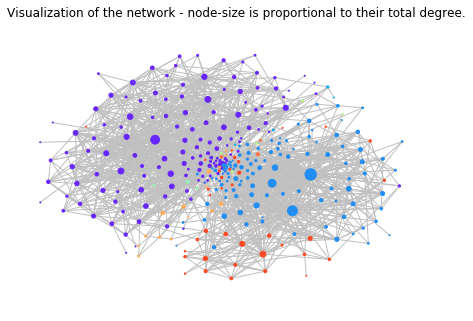

In [16]:
from matplotlib.pyplot import cm

# Init color array
cols = np.full(shape=(dim, 4), fill_value=1.000000)
# List of possible colors
n_of_communities = max(partition.values())
col_list = cm.rainbow(np.linspace(0,1,n_of_communities + 1))
np.random.shuffle(col_list)

# Save colors according to the partition
for i, p in partition.items():
    cols[i] = col_list[p]

nx.draw(H, positions, node_size=[v for v in d.values()], with_labels=False, 
        node_color=cols, edge_color="silver", edge_width=0.5, arrows=False)
plt.title('Visualization of the network - node-size is proportional to their total degree.')
plt.show()

The visualization shows how the communities produced by the Louvain algorithm show clear correlation to the political parties of the politicians. From the visualization it can also be seen that while most of the Democrats and Republicans belong to their corresponding uniform (giant) communities, there exists also smaller sub-communities within parties (most notably within Republicans).

In [17]:
C = np.zeros(shape=(n_of_communities + 1, 2), dtype='int')

for i, p in partition.items():
    party = int(i in republicans)
    C[p][party] += 1
    
C = pd.DataFrame(C)
C.columns = ['Democratic', 'Republican']
C

Democratic  Republican
0            1          35
1          133           6
2            7         105
3            3           1
4            1           2
5            0           1
6            2           1
7            9           6
8            3           3
9            0           1
10           2           3
11           1           0
12           1           0
13           1           0
14           1           0
15           0           1
16           1           0
17           0           1
18           1           0
19           1           0
20           1           0
21           1           0

The confusion matrix is consistent with the visualizations in that the algorithm is able to separate most democrats and republicans into their own communities that correspond to their respective parties. The confusion matrix shows also that these larger communities are not completely pure as less than 8% of their population belong to the opposite party.

The smaller communities generally follow the same pattern (with the exception of 7th and 10th component) having at least 66% of their population belonging to another party (although most of these smaller communities have only one member).

As mentioned before, the algorthm doesn't clearly subdivide the parties except there exists a pure-republican community of 22 members (community 2). Without having a proper knowledge about American politics, an initial guess is that this sub-division might consist of the most conservative right-end republicans.

In [20]:
import pandas as pd
import networkx as nx
import re
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2 as FA2 # pip install fa2
from heapq import nlargest
from operator import itemgetter
import operator
import numpy as np
import community # pip install python-louvain
import random
import io
import unicodedata
import unidecode # pip install Unidecode
from wordcloud import WordCloud # pip install wordcloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import math
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/hamalaja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hamalaja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 2 - What do republican and democratic members tweet about?

**Exercise 4 - TF-IDF of the republican and democratic tweets**

We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud. The procedure you should use is exactly the same you used in exercise 2 of week 7. The main steps are summarized below:

* Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.
* Exclude all twitter handles.
* Exclude punctuation.
* Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
* Exclude numbers (since they're difficult to interpret in the word cloud).
* Set everything to lower case.
* Compute the TF-IDF for each document.
* Now, create word-cloud for each party. Are these topics less "boring" than the wikipedia topics? Why? Comment on the results.            

In [18]:
df2 = pd.read_csv('./115_tw_2019.csv', encoding = "utf-8") # read file with twitter and party associated
RepublicanDocument = "" # create document for republican tweets which is a big string
DemocraticDocument = ""# create document for democratic tweets which is a big string

count_demo = 0 #counter of democratic politician
count_rep = 0 #counter of republican politician

for value in df2.values:
    name = value[0]
    party = value[1]

    with io.open("./tweets_2019_full/" + name, "r", encoding="utf-8") as f:
        tweets = f.read() 
        
    tweets = unicodedata.normalize('NFKD', tweets).encode('ascii','ignore') # unicode to string
    tweets = tweets.decode('utf-8')
    
    tweets = re.sub(r"http\S+", "", tweets) # clear all links
    tweets = re.sub(r"@\S+", "", tweets) # clear all user name
    tweets = re.sub(r'\W+', ' ', tweets) # clear all ponctuation

    if party == "Democratic":
        count_demo += 1 # count number of democratic
        DemocraticDocument += tweets # append tweets from the current reached file
    else:
        count_rep +=1
        RepublicanDocument += tweets

print('done')

NameError: name 'unicodedata' is not defined

In [19]:
# compute Term frequency for each document
from nltk import word_tokenize

# function which take a nltk.Text in parameter and return list of tuple(tokens, occurrence)
def countWord(text):
    fdist = nltk.FreqDist([w.lower() for w in text])
    words = []

    for key in fdist.keys():
        if key not in nltk.corpus.stopwords.words() and key.lower().isalpha(): # transform in lower case and drop numbers
            words.append((fdist[key], key))
    words = sorted(words, reverse=True)
    return words

#Democratic
DemocraticDocumentString = ''

# for value in DemocraticDocument:
#     DemocraticDocumentString = DemocraticDocumentString + str(' ' + value)
    
tokens = nltk.word_tokenize(DemocraticDocument) # tokenize the document 
DemocraticDocument = nltk.Text(tokens) # create Text with the list of token
demo_tockens = countWord(DemocraticDocument) # count occurs
print('done demo')

#Republican
RepublicanDocumentString = ''

# for value in RepublicanDocument:
#     RepublicanDocumentString = RepublicanDocumentString + str(' ' + value)

tokens = nltk.word_tokenize(RepublicanDocument)
RepublicanDocument = nltk.Text(tokens)
repu_tockens = countWord(RepublicanDocument)
print('done repu')

done demo
done repu


In [21]:
# compute Inverse document frequency for each document
demo_idf = {}
repu_idf = {}

# republican
for count, word in repu_tockens:
    repu_idf[word] = math.log10(float(count_rep) / float(count))

# democratic
for count, word in demo_tockens:
    demo_idf[word] = math.log10(float(count_rep) / float(count))

In [22]:
# cast list of tuple to dict 
repu_tockens_dict = {}
for i in range(len(repu_tockens)):
    repu_tockens_dict[repu_tockens[i][1]]= repu_tockens[i][0]

demo_tockens_dict = {}
for i in range(len(demo_tockens)):
    demo_tockens_dict[demo_tockens[i][1]]= demo_tockens[i][0]

In [27]:
# compute Term frequency–Inverse document frequency
demo_tfidf = {}
repu_tfidf = {}

for key, value in repu_idf.items():
    repu_tfidf[key] = repu_tockens_dict[key] * repu_idf[key]

for key, value in demo_idf.items():
    demo_tfidf[key] = demo_tockens_dict[key] * demo_idf[key]
    
print('done')

done


In [24]:
# join words into long string

# democrats
demo_words_sorted = sorted(demo_tfidf.items(), key=lambda x: x[1], reverse=True) # make complete sorted list of words
demo_words_string = ""

for pair in demo_words_sorted:
    for i in range(int(math.ceil(pair[1]))):
        demo_words_string += pair[0] + " "

# republicans
repu_words_sorted = sorted(repu_tfidf.items(), key=lambda x: x[1], reverse=True) # make complete sorted list of words
repu_words_string = ""

for pair in repu_words_sorted:
    for i in range(int(math.ceil(pair[1]))):
        repu_words_string += pair[0] + " "

print('done')

done


In [32]:
# Generate a word cloud images

#source: https://stackoverflow.com/a/43043723
def demo_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 150.0 / 255.0) # hue = 150 for blue
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random.randint(40, 180)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def repu_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 0.0 / 255.0) # hue = 0 for red
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random.randint(40, 180)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

# collocations=False to avoid words like "maryland maryland" in the wordcloud
demo_wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(demo_words_string)
repu_wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(repu_words_string)

demo_wordcloud.recolor(color_func=demo_color_func)
repu_wordcloud.recolor(color_func=repu_color_func)

print('done')

done


Now, create word-cloud for each party.

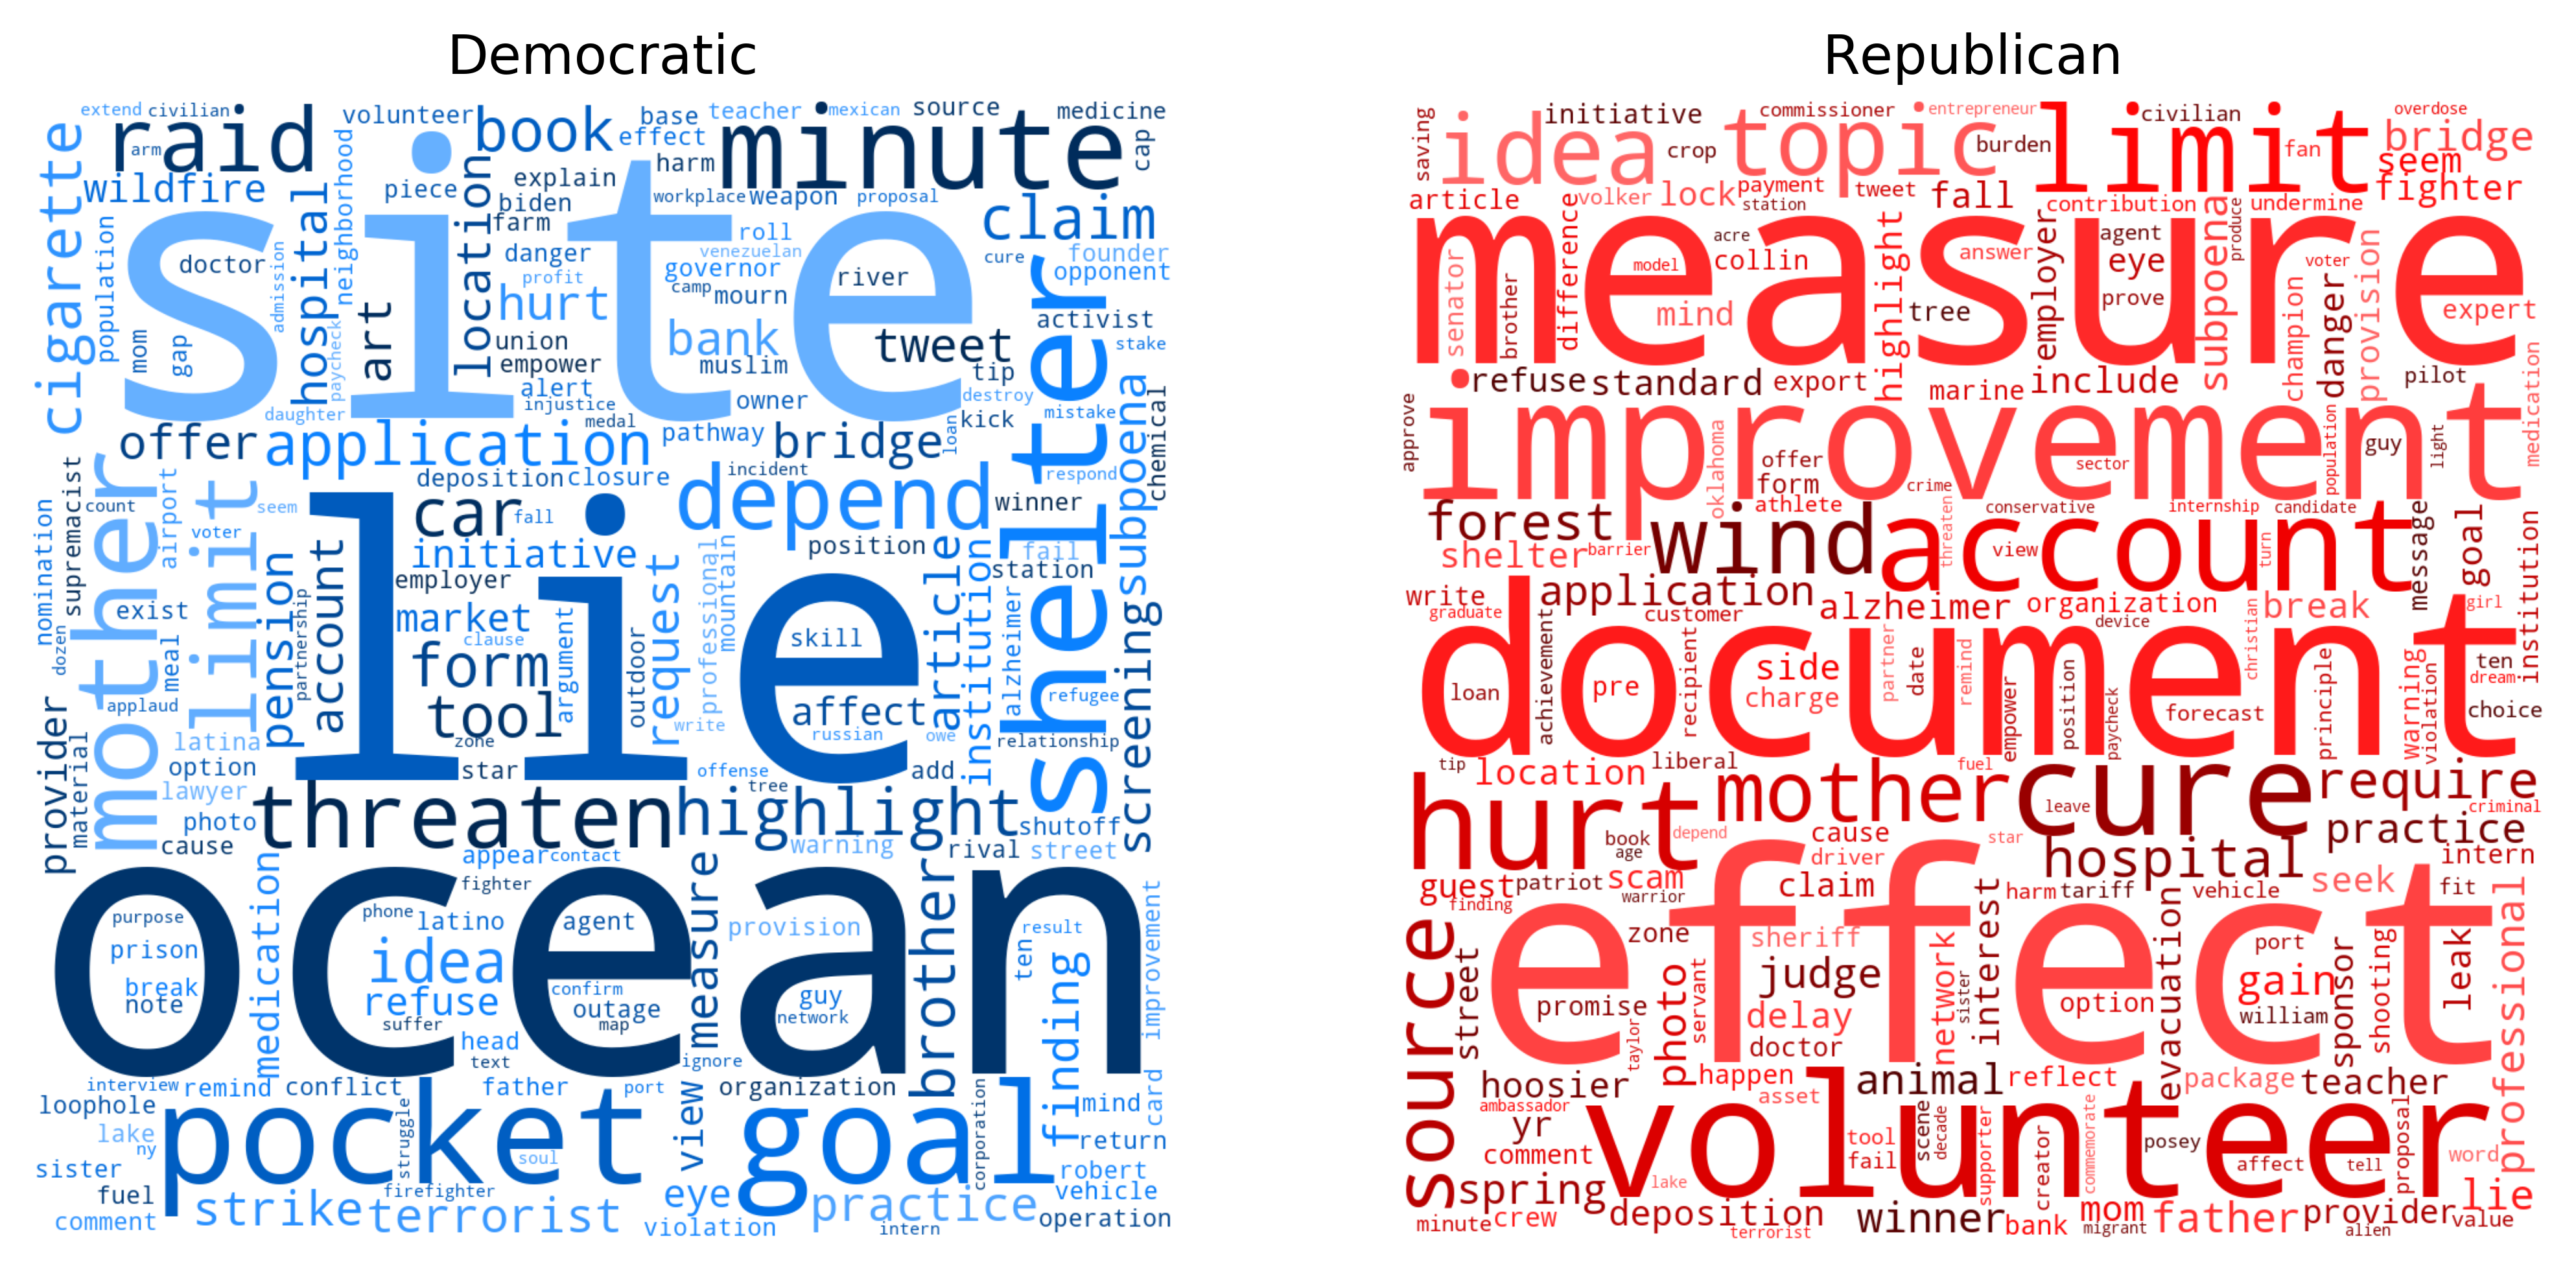

In [33]:
# Display the generated images

# enable plotting in two columns
fig, axs = plt.subplots(ncols=2, figsize=(10, 10), dpi=500)

axs[0].imshow(demo_wordcloud, interpolation='bilinear')
axs[0].set_title("Democratic")
axs[0].axis("off")

axs[1].imshow(repu_wordcloud, interpolation='bilinear')
axs[1].set_title("Republican")
axs[1].axis("off")

plt.show()